In [4]:
%matplotlib notebook
# %matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [5]:
def sqexp(x, xp, tau=1.0, l=3.0):
    """Squared exponential kernel (1 dimensional)
    
    Inputs
    ------
    x : (N), array of multiple inputs
    xp: float
    
    Returns
    -------
    cov (N,) -- Covariance between each input at *x* and the function values at *x*
    """
    cov = tau**2 * np.exp(-1/2 * np.linalg.norm(x - xp)**2 / l**2)
    return cov
def periodic(x, xp, tau=1, l=1.0, p=0.4):
    """Periodic kernel"""
    return tau**2 * np.exp ( -2 * np.sin(np.pi * np.abs(x - xp) / p )**2 / l**2)
def poly(x, xp, c=1, d=3):
    """Polynomial kernel"""
    return (x * xp + c)**d
    
KERNELS = {"Sq.Exp":sqexp, "Periodic":periodic, "Poly":poly}

In [6]:
def build_covariance(x, xp, kern):
    """Build a covariance matrix
    
    Inputs
    -------
    x: (N) array of inputs
    xp: (M) array of inptus
    kern: a function mapping inputs to covariance
    
    Outputs
    -------
    cov: (N, M) covariance matrix
    """
    out = np.zeros((x.shape[0], xp.shape[0]))
    for jj in range(xp.shape[0]):
        for ii in range(x.shape[0]):
            out[ii, jj] = kern(x[ii], xp[jj])
    return out

In [19]:
def gpr(xtrain, ytrain, xpred, noise_var, mean_func, kernel):
    """Gaussian process regression Algorithm

    Inputs
    -------
    xtrain: (N, ) training inputs
    ytrain: (N, ) training outputs
    xpred:  (M, ) locations at which to make predictions
    noise_var: (N, ) noise at every training output
    mean_func: function to compute the prior mean
    kernel: covariance kernel
    
    Returns
    -------
    pred_mean : (M, ) predicted mean at prediction points
    pred_cov : (M, M) predicted covariance at the prediction points
    --
    """
    
    cov = build_covariance(xtrain, xtrain, kernel)
    u, s, v = np.linalg.svd(cov)
    sqrtcov = np.dot(u, np.sqrt(np.diag(s)))

    # pseudoinverse is better conditioned
    invcov = np.linalg.pinv(cov + np.diag(noise_var))
    
    vec_pred = build_covariance(xpred, xtrain, kernel)

    pred_mean = mean_func(xpred) + vec_pred @ invcov @ (ytrain - mean_func(xtrain))
    
    cov_predict_pre = build_covariance(xpred, xpred, kernel)
    cov_predict_up = vec_pred @ invcov @ vec_pred.T
    pred_cov = cov_predict_pre - cov_predict_up
    pred_cov[ pred_cov < 0 ] = 0
    
    return pred_mean, pred_cov

In [20]:
def log_likelihood(xtrain, ytrain, noise_var, mean_func, kernel):
    cov = build_covariance(xtrain, xtrain, kernel)
    n = np.shape(cov)[0]  # assuming a square matrix
    likelihood = -1/2*( ytrain - mean_func(xtrain) ).T @ np.linalg.inv(cov + noise_var*np.eye(n)) @ ( ytrain - mean_func(xtrain)) - 1/2*np.log( np.abs(cov + noise_var*np.eye(n)) ) - n/2*np.log(2*np.pi)
    return likelihood

## Plot given data

<IPython.core.display.Javascript object>


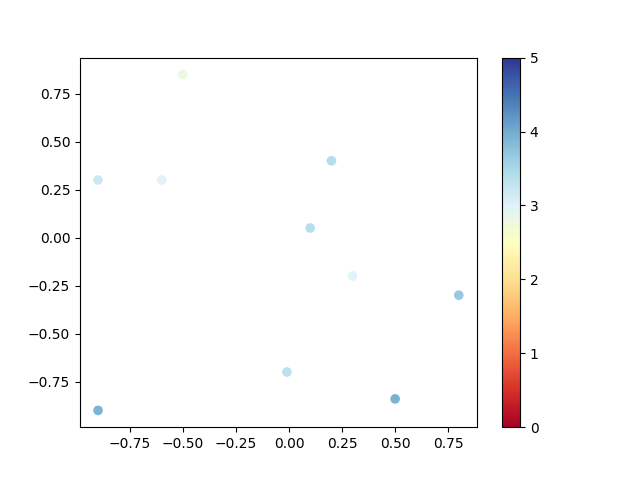

<IPython.core.display.Javascript object>


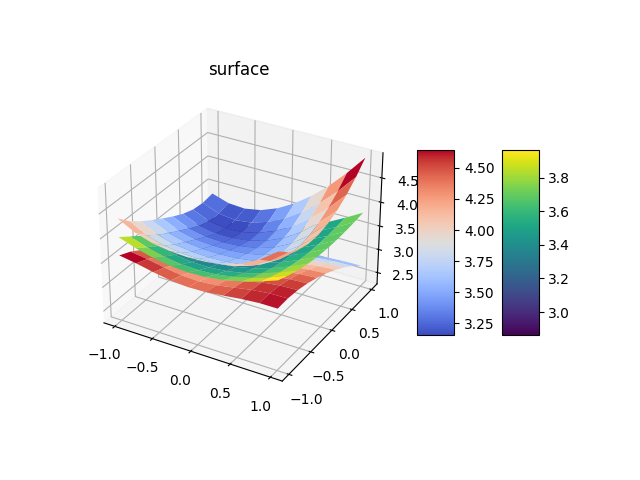

In [47]:
train_x0 = np.asarray([0.1, -0.9, 0.2, 0.8 ,-0.6, 0.3, 0.5, -0.5, -0.01, -0.9])
train_y0 = np.asarray([0.05, 0.3, 0.4, -0.3 ,0.3, -0.2 ,-0.84 ,0.85, -0.7, -0.9])
train_output0 = np.asarray([3.39382006, 3.2073034, 3.39965035, 3.68810201, 2.96941623, 2.99495501, 3.94274928 ,2.7968011, 3.34929734, 3.9129616]).reshape(-1,1);
train_input0 = np.concatenate((train_x0.reshape(-1,1),train_y0.reshape(-1,1)),axis=1)

# generate test data
num_div = 10
x = np.linspace(-1,1,num_div)#.reshape(-1,1)
y = np.linspace(-1,1,num_div)#.reshape(-1,1)
X, Y = np.meshgrid(x,y)

# converting from meshgrid format to a list of points
pred_input = np.concatenate((X.reshape(-1,1),Y.reshape(-1,1)),axis=1)

noise_cov = 0.001
mean_func = lambda x: np.zeros((x.shape[0],1))

mean, cov = gpr(train_input0, train_output0, pred_input, noise_cov * np.ones((train_input0.shape[0])), mean_func, sqexp)

# Extracting only the diaginal elements: variance from covariance matrix
var = np.diag(cov).reshape(-1,1)

# converting from list of means to meshgrid format
pred_mean = mean.reshape(-1,1).reshape(num_div,num_div)
pred_var = var.reshape(-1,1).reshape(num_div,num_div)

beta = 10
upper_confidence_layer = pred_mean + beta*np.sqrt(pred_var)
lower_confidence_layer = pred_mean - beta*np.sqrt(pred_var)

# plot original points
cm = plt.cm.get_cmap('RdYlBu')
sc = plt.scatter(train_x0, train_y0, c=train_output0, vmin=0, vmax=5, s=35, cmap=cm)
plt.colorbar(sc)

# plotting mesh data
fig = plt.figure()
ax = plt.axes(projection='3d')
p1 = ax.plot_surface(X, Y, pred_mean, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
p2 = ax.plot_surface(X, Y, upper_confidence_layer, rstride=1, cstride=1,
                cmap=plt.cm.coolwarm, edgecolor='none')
p3 = ax.plot_surface(X, Y, lower_confidence_layer, rstride=1, cstride=1,
                cmap=plt.cm.coolwarm, edgecolor='none')
fig.colorbar(p1, shrink=0.5, aspect=5)
fig.colorbar(p2, shrink=0.5, aspect=5)
ax.set_title('surface');


## Plotting